In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
#from tensorflow.keras.utils import set_random_seed
#set_random_seed(1)
plt.rcParams["figure.figsize"] = (12,7)
sns.set_style("darkgrid")

The space embeddings dataframe, that was created in [Descriptive Statistics](./DescriptiveStatistics.ipynb) and enriched through [NLP Classification](./NLPClassification.ipynb), is loaded and split into ***X*** and ***y*** matrices used as inputs for our neural network. Normally, one would use the features to predict a target in a machine learning, but it will be done oppositely when trying to learn embeddings for a target or in our case a grid cell. 

Therefore, ***X*** simply contains a one-hot encoding of all the grid cells, which makes it a 480x480 diagonal matrix with ones. The ***y*** matrix contains the features from the space embeddings dataframe and is shown below.

In [13]:
# Load space embeddings data and prepare X and y matrices
df = pd.read_csv("data/space_embedding_data.csv", index_col=[0])
y = df[[i for i in df.columns if "_rating" not in i]].drop(["Grid"], axis=1)
X = pd.get_dummies(df.Grid).values

print("Targets (y) shape:", y.shape)
print("Input (X) shape:", X.shape)
y.head()

Targets (y) shape: (480, 21)
Input (X) shape: (480, 480)


,PlaceCount,Price 1,Price 2,Price 3,Accommodation,Bar,Cafe,Cultural,Education,Health,...,Outdoors,Restaurant,Retail,Service,Wholesale,ReviewCount,Rating,PositiveReviews,NegativeReviews,ReviewLength
0,8,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,5.0,0.0,1.0,0.0,125,3.968571,0.696000,0.304000,0.536595
1,10,0,1,0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,2.0,0.0,2.0,1.0,31,4.592593,0.851852,0.148148,0.802238
2,3,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,8,4.200000,0.857143,0.142857,0.999095
3,74,2,9,6,12.0,6.0,6.0,0.0,1.0,4.0,...,0.0,17.0,4.0,7.0,1.0,853,3.694524,0.732975,0.267025,0.895548
4,163,7,31,5,21.0,19.0,20.0,1.0,1.0,10.0,...,0.0,37.0,21.0,9.0,5.0,1330,3.719004,0.801535,0.198465,0.843739


It is chosen to scale the targets in order for them to be weighted as equal as possible in the loss function.

In [14]:
# Standard scaling of targets/features
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
y_tf = sc.fit_transform(y)

# Space Embeddings model

Now that the data for the space embeddings model has been prepared, it is time to get a better understanding of the space embeddings model. The model is a shallow neural network illustrated by a simplified drawing below:

![NN architecture](img/NN_Architecture.png)

It is seen that the model takes an input of shape (, 480), which is equal to the number of grid cells in our dataset, and feeds it to an embedding layer, which outputs embeddings of shape (, 480, *n*). The *n* refers to the length of the embedding vector, which will be found through hyperparameter tuning, but it is essential that $n<m$ where *m* is the number of features per grid cell, since we are trying to map high-dimensional data to a lower dimension. The embeddings are then flattened and fed into *m* output layers, which will output a single prediction for each feature. Thus, the neural network has *m* losses where the hyperparameter tuning will optimize the aggregation of these *m* losses.

The illustration above considers a regression task with continuous parameters and one output per feature, which will be one of two approaches conducted in this notebook:
1. A neural network with continuous targets and regression metrics
2. A neural network with uniform categorical targets and classification metrics

The first approach requires no data processing and is relatively easy to implement given the nature of the data and the architecture of such a neural network. The idea for the second approach came from a discussion with our mentor, who has had success with using categorical data where the classes are uniformly distributed. This approach will require the final output layers to be categorical where ambiguity can arise regarding the architecture.

Due to the many similarities between the two approaches, the first approach will be described more thoroughly where only differences will be highlighted in the second approach.

## Continuous features

The architecture for the two neural networks will be close to identical with the exception of the output layer(s). Naturally, the output activation and the loss function should be appropriate for a regression task, which is why a linear activation is used with a mean squared error loss. The following uses `keras-tuner` to tune the length of the embedding vector and the learning rate.

In [17]:
from keras.models import Model
from keras.layers import Dense, Embedding, Flatten
from keras import Input
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from keras.callbacks import EarlyStopping
# https://www.tensorflow.org/tutorials/keras/keras_tuner
def model_builder_continuous(hp):
    input_neurons = X.shape[0]

    # Model architecture
    inp = Input(shape=(input_neurons,))
    hp_embedding = hp.Int("units", min_value=5, max_value=15, step=1)
    emb = Embedding(input_dim=input_neurons, output_dim=hp_embedding, input_length=input_neurons)(inp)
    flat = Flatten()(emb)

    # Output layer(s) - create dict of losses to save losses and list of output layers
    dict_losses = {}
    output_acts = []
    for idx in range(len(y.columns)):
        output_act = Dense(1, activation="linear", use_bias=True, name="output_layer_cont" + str(idx))(flat)
        output_acts.append(output_act)
        dict_losses['output_layer_cont' + str(idx)] = 'mean_squared_error'

    # Model compiling
    model = Model(inputs=inp, outputs=output_acts)
    hp_learning_rate = hp.Choice('learning_rate', values=[3e-4, 0.001, 0.01, 0.1])
    opt = Adam(learning_rate=hp_learning_rate)
    model.compile(loss=dict_losses, optimizer=opt)
    return model


In [86]:
objective = kt.Objective("loss", direction="min")
tuner = kt.Hyperband(model_builder_continuous,
                    objective=objective,
                    max_epochs=10,
                    directory="hyperparameter_tuning",
                    project_name="continuous_trials",
                    overwrite=False
)

stop_early = EarlyStopping(monitor="loss", patience=5)

tuner.search(X, y_tf, callbacks=[stop_early])
best_hps = tuner.get_best_hyperparameters()[0]

Trial 30 Complete [00h 00m 10s]
loss: 11.953197479248047

Best loss So Far: 11.953197479248047
Total elapsed time: 00h 03m 49s
INFO:tensorflow:Oracle triggered exit


The best model obtained in the tuning process is saved and trained for more epochs to better fit the targets.

In [87]:
# Rebuild model with best hyperparameters
model = tuner.hypermodel.build(best_hps)

# train model for 50 epochs
history = model.fit(X, y_tf, epochs=50, verbose=0)
train_loss_per_epoch = history.history['loss']

To get the model at the epoch where it was best, the epoch of the lowest loss is found and the model is retrained.

In [88]:
# Find best epoch in terms of train loss
best_epoch = train_loss_per_epoch.index(min(train_loss_per_epoch)) + 1

# Retrain the model with optimal epochs from above
hypermodel = tuner.hypermodel.build(best_hps)
hypermodel.fit(X, y_tf, epochs=best_epoch, verbose=0)

When fitting the space embeddings, we are interested in overfitting the current problem as much as possible. Therefore, we are simply interested in getting as low a loss as possible without having to worry about performance on validation or test sets.

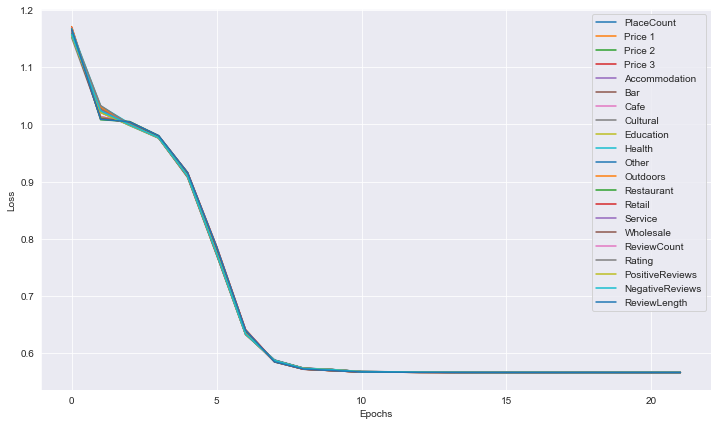

In [134]:
for idx, (key, value) in enumerate(hypermodel.history.history.items()):
    if key != "loss":
        plt.plot(hypermodel.history.epoch, value, label=y.columns[idx-1])
plt.ylabel("Loss")
plt.xlabel("Epochs");
plt.legend();

In [103]:
import pickle
weights = hypermodel.layers[1].get_weights()[0].tolist()
grids = df.Grid.values
ws = {grids[i]: weights[i] for i in range(len(df))}
with open("embeddings/continuous_embeddings.pkl", "wb") as f:
    pickle.dump(ws, f)

## Discrete/categorical features

In [18]:
# Defining a function for uniform discretizing of the features
# Can only handle features with less than 20% zero values. 
# Minimum number of bins are set to 3 and the maximum number of bins are 10

def uniform_Discretization(array):
    minspan = []
    
    # max number og bins is 10 (7+3)
    max_bins = 7
    #if input contains zeros, adjust max number of bins
    if np.any(array==0):
        max_bins = np.int32(np.floor(1/(len(np.where(array==0)[0])/len(array))))-2

    # find optimal number of bins with least variation in binsize
    # min number og bins = 3
    for i in range(max_bins-3):
        Value_count = pd.qcut(array,i+3).value_counts()
        minspan.append(max(Value_count)-min(Value_count))

    bins = np.argmin(minspan)+3
    intervals = np.unique(pd.qcut(array,bins))
    
    # print number of bins and bin intervals
    print(array.name,'- Bins: ', bins,'--',' '.join(str(x) for x in intervals))
    
    # uniform discretized bin 
    uniform_vals = pd.qcut(array,bins, labels=False)
    
    return uniform_vals


In [19]:
import pandas as pd
# Transforming the dataset to uniform discretized values, for features with less than 20% zeros
y_discrete = pd.DataFrame()
for i in range(len(y.columns)-1):
    columns = y.columns
    
    if len(np.where(y[columns[i+1]]==0)[0])/len(y[columns[i+1]])<0.2:
        y_discrete[columns[i+1]] = uniform_Discretization(y[columns[i+1]])
        y_discrete[columns[i+1]] = y_discrete[columns[i+1]].astype("category", copy=False)
    else:
        0
    #data[columns[i+]] = uniform_Discretization(df[columns[i+1]])

Bar - Bins:  3 -- (-0.001, 2.0] (2.0, 6.0] (6.0, 133.0]
Other - Bins:  3 -- (-0.001, 2.0] (2.0, 6.0] (6.0, 91.0]
Restaurant - Bins:  3 -- (-0.001, 3.0] (3.0, 13.0] (13.0, 263.0]
ReviewCount - Bins:  5 -- (3.999, 40.8] (40.8, 99.2] (99.2, 225.4] (225.4, 638.2] (638.2, 8699.0]
Rating - Bins:  3 -- (1.5550000000000002, 3.941] (3.941, 4.13] (4.13, 5.0]
PositiveReviews - Bins:  4 -- (0.311, 0.792] (0.792, 0.833] (0.833, 0.864] (0.864, 1.0]
NegativeReviews - Bins:  4 -- (-0.001, 0.136] (0.136, 0.167] (0.167, 0.208] (0.208, 0.688]
ReviewLength - Bins:  3 -- (0.0665, 0.899] (0.899, 1.099] (1.099, 2.218]


In [83]:
data = []
for c in y_discrete:
    arr = np.asarray(pd.get_dummies(y_discrete[c]).values)
    data.append(arr)

In [84]:
data

[array([[1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        ...,
        [1, 0, 0],
        [1, 0, 0],
        [0, 0, 1]], dtype=uint8),
 array([[1, 0, 0],
        [0, 1, 0],
        [1, 0, 0],
        ...,
        [1, 0, 0],
        [1, 0, 0],
        [0, 0, 1]], dtype=uint8),
 array([[0, 1, 0],
        [1, 0, 0],
        [1, 0, 0],
        ...,
        [1, 0, 0],
        [1, 0, 0],
        [0, 0, 1]], dtype=uint8),
 array([[0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        ...,
        [0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1]], dtype=uint8),
 array([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        ...,
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]], dtype=uint8),
 array([[1, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 1, 0],
        ...,
        [1, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 1]], dtype=uint8),
 array([[0, 0, 0, 1],
        [0, 1, 0, 0],
        [0, 1, 0, 0],
        ...,
        [0, 0, 

In [20]:
categ_Ys=[]
for col in y_discrete.columns:
    y_=y_discrete[col].values
    y_=y_.ravel()
    categ_Ys.append(y_)

In [21]:
'''Utilities functions'''
def create_index(alfabet):
    index2alfa={}
    alfa2index={}
    for i in range(len(alfabet)):
        index2alfa[i]=alfabet[i]
        alfa2index[alfabet[i]]=i
    return index2alfa, alfa2index
#returns mapping dicionarity alfabet -> one-hot encoding index
def one_hot_enc(x, size):
    vec = np.zeros(size)
    vec[x] = 1
    return vec

In [22]:
n_classes=[]
all_index2alfa_to=[]
all_alfa2index_to=[]
for cat_y in categ_Ys:
    y_alf=np.unique(cat_y)
    index2alfa_to, alfa2index_to = create_index(y_alf)
    all_index2alfa_to.append(index2alfa_to)
    all_alfa2index_to.append(alfa2index_to)
    n_classes.append(len(alfa2index_to))

In [57]:
output_space = []
for idx,cat_y in enumerate(categ_Ys):
    current_Y=[]
    for yi in cat_y:
        one_hot= np.array(one_hot_enc(all_alfa2index_to[idx][yi], n_classes[idx]))
        #print(one_hot)
        current_Y.append(one_hot)
    output_space.append(np.array(current_Y))

In [12]:
#y_discrete = pd.get_dummies(y_discrete)
#y_discrete = y_discrete.astype(float)
y_discrete.head()

,Bar,Other,Restaurant,ReviewCount,Rating,PositiveReviews,NegativeReviews,ReviewLength
0,0,0,1,2,1,0,3,0
1,0,1,0,0,2,2,1,0
2,0,0,0,0,2,2,1,1
3,1,2,2,4,0,0,3,0
4,2,2,2,4,0,1,2,0


In [86]:
input_neurons = X.shape[0]

# Model architecture
inp = Input(shape=(input_neurons,))
#hp_embedding = hp.Int("units", min_value=3, max_value=6, step=1)
emb = Embedding(input_dim=input_neurons, output_dim=5, input_length=input_neurons)(inp)
flat = Flatten()(emb)

# Output layer
dict_losses = {}
output_acts = []
for idx in range(len(y_discrete.columns)):
    n_output = y_discrete.iloc[:, idx].nunique()
    #print(n_output)
    output_act = Dense(n_output, activation="softmax", use_bias=True, name="output_layer_cat" + str(idx))(flat)
    #print(output_act)
    output_acts.append(output_act)
    dict_losses['output_layer_cat' + str(idx)] = 'categorical_crossentropy'

# Model compiling
model = Model(inputs=inp, outputs=output_acts)
opt = Adam(learning_rate=0.001)
model.compile(loss=dict_losses, optimizer=opt)
#model.fit(X, output_space)
model.fit(X, data)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
15/15 [==============================] - 2s 4ms/step - loss: 9.9334 - output_layer_cat0_loss: 1.0936 - output_layer_cat1_loss: 1.1008 - output_layer_cat2_loss: 1.0977 - output_layer_cat3_loss: 1.6248 - output_layer_cat4_loss: 1.1094 - output_layer_cat5_loss: 1.4014 - output_layer_cat6_loss: 1.4019 - output_layer_

In [87]:
def model_builder_discrete(hp):
    input_neurons = X.shape[0]

    # Model architecture
    inp = Input(shape=(input_neurons,))
    hp_embedding = hp.Int("units", min_value=3, max_value=6, step=1)
    emb = Embedding(input_dim=input_neurons, output_dim=hp_embedding, input_length=input_neurons)(inp)
    flat = Flatten()(emb)

    # Output layer
    dict_losses = {}
    output_acts = []
    for idx in range(len(y_discrete.columns)):
        n_output = y_discrete.iloc[:, idx].nunique()
        output_act = Dense(n_output, activation="softmax", use_bias=True, name="output_layer_cat" + str(idx))(flat)
        output_acts.append(output_act)
        dict_losses['output_layer_cat' + str(idx)] = 'categorical_crossentropy'

    # Model compiling
    model = Model(inputs=inp, outputs=output_acts)
    hp_learning_rate = hp.Choice('learning_rate', values=[3e-4, 0.001, 0.01, 0.1])
    opt = Adam(learning_rate=hp_learning_rate)
    model.compile(loss=dict_losses, optimizer=opt)
    return model

In [90]:
objective = kt.Objective("loss", direction="min")
tuner = kt.Hyperband(model_builder_discrete,
                    objective=objective,
                    max_epochs=10,
                    directory="hyperparameter_tuning",
                    project_name="discrete_trials",
                    overwrite=True
)

stop_early = EarlyStopping(monitor="loss", patience=5)

#tuner.search(X, output_space, callbacks=[stop_early])
tuner.search(X, data, callbacks=[stop_early])

best_hps = tuner.get_best_hyperparameters()[0]

INFO:tensorflow:Reloading Oracle from existing project hyperparameter_tuning\discrete_trials\oracle.json

Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
4                 |?                 |units
0.01              |?                 |learning_rate
2                 |?                 |tuner/epochs
0                 |?                 |tuner/initial_epoch
2                 |?                 |tuner/bracket
0                 |?                 |tuner/round

Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full ou

NotFoundError: Failed to create a NewWriteableFile: hyperparameter_tuning\discrete_trials\trial_0000\checkpoint_temp/part-00000-of-00001.data-00000-of-00001.tempstate13108824452395000909 : The system cannot find the path specified.
; No such process [Op:SaveV2]

In [89]:
# Rebuild model with best hyperparameters
model = tuner.hypermodel.build(best_hps)

# train model for 50 epochs
history = model.fit(X, data, epochs=50, verbose=0)

train_loss_per_epoch = history.history['loss']

NameError: name 'best_hps' is not defined

In [50]:
# Find best epoch in terms of train loss
best_epoch = train_loss_per_epoch.index(min(train_loss_per_epoch)) + 1

# Retrain the model with optimal epochs from above
hypermodel = tuner.hypermodel.build(best_hps)
hypermodel.fit(X, output_space, epochs=best_epoch, verbose=0)

# Save model
hypermodel.save("models/discrete_model")

INFO:tensorflow:Assets written to: models/discrete_model\assets


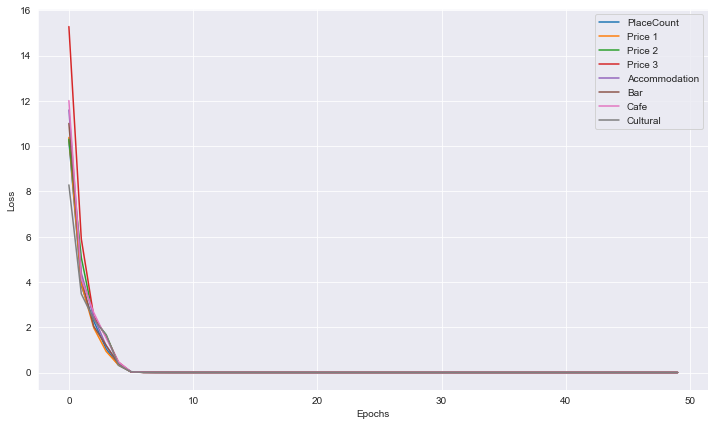

In [51]:
for idx, (key, value) in enumerate(hypermodel.history.history.items()):
    if key != "loss":
        plt.plot(hypermodel.history.epoch, value, label=y.columns[idx-1])
plt.ylabel("Loss")
plt.xlabel("Epochs");
plt.legend();

In [52]:
import pickle
weights = hypermodel.layers[1].get_weights()[0].tolist()
grids = df.Grid.values
ws = {grids[i]: weights[i] for i in range(len(df))}
with open("embeddings/discrete_embeddings.pkl", "wb") as f:
    pickle.dump(ws, f)

## Model comparison (Continuous vs Discrete/Categorical)

Compare models and find the "best" model. Plot loss curves and TSNE for the best model

In [114]:
from tensorflow import keras
model = keras.models.load_model("models/continuous_model")

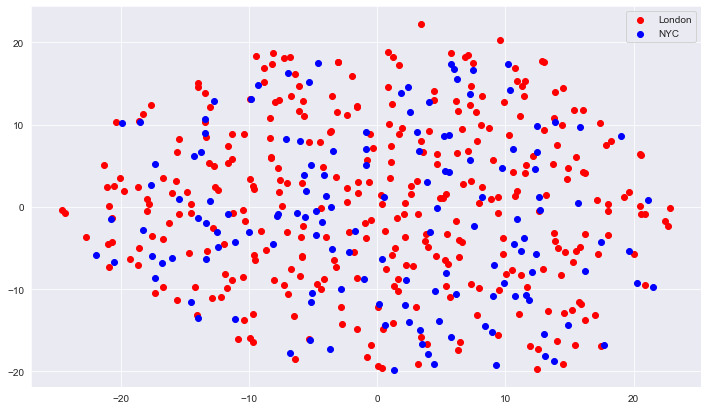

In [146]:
from sklearn.manifold import TSNE
# Apply TSNE to lower dimension of embeddings
embeddings = model.layers[1].get_weights()[0]
X_emb = TSNE(n_components=2, learning_rate="auto", init="random").fit_transform(embeddings)

# Find index of London and NYC grids for scatter plot
london_idx = np.where((df.Grid.str.startswith("L")*1).values==1)
nyc_idx = np.where((df.Grid.str.startswith("N")*1).values==1)
plt.scatter(X_emb[london_idx, 0], X_emb[london_idx, 1], color="red", label="London")
plt.scatter(X_emb[nyc_idx, 0], X_emb[nyc_idx, 1], color="blue", label="NYC")
plt.legend()


The scatter plot shows that there is no apparent clustering, i.e. in terms of a NYC vs London cluster. This is a great sign, since it indicates that there are similarities between grids across country borders. Thus,